In [26]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
import shap
sns.set_theme()

In [27]:
data = pd.read_csv("../data/ml_data_w_risk_questions_processed_final.csv")
data.head()

,ohe__religion_10,cat__sex,cat__income,cat__education,cat__prior_surg,cat__succ_surg,num__age,num__odi_final,num__bmi,num__dospert_ethical,...,work_50improv_90para,work_90improv_1para,work_90improv_10para,work_90improv_50para,work_50improv_1death,work_50improv_10death,work_50improv_50death,work_90improv_1death,work_90improv_10death,work_90improv_50death
0,0.0,-1.015351,-0.559237,0.390836,0.604824,0.628025,-1.451225,-0.841732,-0.995194,0.634665,...,0,5,5,0,5,3,0,5,5,0
1,0.0,-1.015351,1.737435,0.390836,0.604824,0.628025,-1.298420,-0.705424,-0.731667,1.253831,...,0,5,3,2,4,2,1,5,3,1
2,1.0,0.911646,1.227063,0.390836,0.604824,0.628025,-1.705898,-0.978040,-1.087988,-0.397279,...,0,2,1,0,1,0,0,1,0,0
3,0.0,-1.015351,-0.048865,1.046883,0.604824,0.628025,-1.145616,-0.296500,0.634121,-0.603668,...,0,4,3,0,3,0,0,3,2,0
4,1.0,-1.015351,-0.559237,1.046883,0.604824,0.628025,-1.451225,-0.841732,-0.245044,0.015499,...,0,5,4,1,5,4,1,5,4,1


In [28]:
# Fix column names
cols = list(data.columns)
new_cols = [re.sub('^[A-z]{3}__', '', c) for c in cols]
data.columns = new_cols

# Drop spinal risk score
data.drop(columns=['spinal_risk_score'], inplace=True)
data.columns

Index(['religion_10', 'sex', 'income', 'education', 'prior_surg', 'succ_surg',
       'age', 'odi_final', 'bmi', 'dospert_ethical', 'dospert_financial',
       'dospert_health/safety', 'dospert_recreational', 'dospert_social',
       'height_m', 'weight_kg', 'ADI_NATRANK', 'ADI_STATERNK',
       'exer_50improv_1drop', 'exer_50improv_10drop', 'exer_50improv_50drop',
       'exer_50improv_90drop', 'exer_90improv_1drop', 'exer_90improv_10drop',
       'exer_90improv_50drop', 'exer_90improv_90drop', 'exer_50pain_1death',
       'exer_50pain_10death', 'exer_50pain_50death', 'exer_90pain_1death',
       'exer_90pain_10death', 'exer_90pain_50death', 'work_50improv_1drop',
       'work_50improv_10drop', 'work_50improv_50drop', 'work_50improv_90drop',
       'work_90improv_1drop', 'work_90improv_10drop', 'work_90improv_50drop',
       'work_50improv_1para', 'work_50improv_10para', 'work_50improv_50para',
       'work_50improv_90para', 'work_90improv_1para', 'work_90improv_10para',
       'work_

In [29]:
data_long = pd.melt(data,
                    id_vars=['religion_10', 'sex', 'income', 'education', 'prior_surg', 'succ_surg',
                             'age', 'odi_final', 'bmi', 'dospert_ethical', 'dospert_financial',
                             'dospert_health/safety', 'dospert_recreational', 'dospert_social',
                             'height_m', 'weight_kg', 'ADI_NATRANK', 'ADI_STATERNK'],
                    var_name='risk_question', value_name='choice')
split_df = data_long['risk_question'].str.split('_', expand=True)
# data_long['choice'] = data_long['choice'] + 1
data_long['activity'] = split_df[0]
data_long['pct_improv'] = split_df[1].str.extract(r'(\d{1,})', expand=False)
data_long['comp'] = split_df[2].str.extract(r'(drop|para|death)', expand=False)
data_long['pct_comp'] = split_df[2].str.extract(r'(\d{1,})', expand=False)
for c in ['pct_improv', 'pct_comp']:
    data_long[c] = pd.to_numeric(data_long[c])

In [30]:
ohe_cols = ['activity', 'comp']
num_cols = ['pct_improv', 'pct_comp']

In [31]:
# define preprocessing pipeline
ohe_pipe = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_cols),
        ('num', num_pipe, num_cols)
    ])

preprocessor.fit(data_long)  # Fit the ColumnTransformer to your data
transformed_columns = preprocessor.get_feature_names_out(input_features=data_long.columns)

processed = preprocessor.fit_transform(data_long)
processed_df = pd.DataFrame(processed, columns=transformed_columns)
cols = list(processed_df.columns)
new_cols = [re.sub('^[A-z]{3}__', '', c) for c in cols]
processed_df.columns = new_cols

drop_cols = ohe_cols + num_cols + ['risk_question']
data_long.drop(columns=drop_cols, inplace=True)
model_data = pd.concat([data_long, processed_df], axis=1)
model_data

,religion_10,sex,income,education,prior_surg,succ_surg,age,odi_final,bmi,dospert_ethical,...,height_m,weight_kg,ADI_NATRANK,ADI_STATERNK,choice,activity_work,comp_drop,comp_para,pct_improv,pct_comp
0,0.0,-1.015351,-0.559237,0.390836,0.604824,0.628025,-1.451225,-0.841732,-0.995194,0.634665,...,-0.551831,-1.100657,-0.450913,-1.118697,4,0.0,1.0,0.0,-0.942809,-0.915608
1,0.0,-1.015351,1.737435,0.390836,0.604824,0.628025,-1.298420,-0.705424,-0.731667,1.253831,...,1.178208,-0.223692,0.320334,0.337078,4,0.0,1.0,0.0,-0.942809,-0.915608
2,1.0,0.911646,1.227063,0.390836,0.604824,0.628025,-1.705898,-0.978040,-1.087988,-0.397279,...,-1.046128,-1.335940,0.026525,-0.754753,3,0.0,1.0,0.0,-0.942809,-0.915608
3,0.0,-1.015351,-0.048865,1.046883,0.604824,0.628025,-1.145616,-0.296500,0.634121,-0.603668,...,0.683911,0.931335,-1.662873,-1.482640,3,0.0,1.0,0.0,-0.942809,-0.915608
4,1.0,-1.015351,-0.559237,1.046883,0.604824,0.628025,-1.451225,-0.841732,-0.245044,0.015499,...,1.425357,0.396601,-0.597818,-1.482640,5,0.0,1.0,0.0,-0.942809,-0.915608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27161,0.0,-1.015351,-1.324794,0.390836,0.604824,0.628025,-1.705898,-0.978040,-0.547173,-0.397279,...,1.178208,-0.031187,0.357060,0.337078,0,1.0,0.0,0.0,1.060660,0.714096
27162,0.0,0.911646,-1.324794,0.390836,-1.653374,-1.592293,-1.298420,-0.569116,0.176618,1.460220,...,-0.304682,0.011591,0.283608,0.701022,0,1.0,0.0,0.0,1.060660,0.714096
27163,0.0,-1.015351,-0.559237,-0.265210,-1.653374,-1.592293,-0.483465,-0.296500,-0.344790,-0.397279,...,1.425357,0.289654,1.752649,1.792853,0,1.0,0.0,0.0,1.060660,0.714096
27164,1.0,0.911646,1.482249,1.702929,0.604824,0.628025,0.738968,-0.569116,0.371300,-1.016445,...,-0.304682,0.182707,-1.552695,-1.118697,0,1.0,0.0,0.0,1.060660,0.714096


In [32]:
X = model_data.drop(['choice'], axis=1)  # All columns except the last one are predictors
y = model_data['choice'].to_numpy()   # The last column is the response variable

# Dropping additional columns
# X = X.drop(['num__height_m', 'num__ADI_STATERNK'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [33]:
# Define models
models = {
    'Ridge': Ridge(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
    # 'LGBM': LGBMClassifier()
    # 'SVM': SVC()
}

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': np.arange(50, 200, 10),
        'learning_rate': np.linspace(0.005, 0.1, 25),
        'max_depth': np.arange(2, 12, 2),
        'subsample': np.linspace(0.5, 1, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'gamma': np.linspace(0, 0.5, 5),
        'colsample_bytree': np.linspace(0.5, 1, 5)
    },
    'Ridge': {
        'alpha': [0, 1, 2]
    },
    'LGBM': {
        'n_estimators': np.arange(50, 200, 10),
        'boosting_type': ['gbdt', 'dart', 'rf'],
        'learning_rate': np.linspace(0.005, 0.1, 25),
        'max_depth': np.arange(2, 12, 2),
        'subsample': np.linspace(0.5, 1, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'colsample_bytree': np.linspace(0.5, 1, 5),
        'verbose': [-1]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf']
    }
}
SEARCH_METHOD = 'random'
degree = 2

# Perform hyperparameter tuning and model training
predictions = {}
train_predictions = {}
best_models = {}
best_params = {}
for model_name, model in models.items():
    if model_name in param_grids:
        if SEARCH_METHOD == 'grid':
            # Perform hyperparameter tuning
            grid_search = GridSearchCV(model, param_grids[model_name], cv=6, scoring='neg_mean_squared_error')
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=degree)),
                ('grid_search', grid_search)
            ])
        else:
            # Perform hyperparameter tuning using RandomizedSearchCV
            randomized_search = RandomizedSearchCV(model, param_grids[model_name], n_iter=10, cv=10, n_jobs=-1,
                                                   scoring='neg_mean_squared_error', random_state=42)
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=degree)),
                ('randomized_search', randomized_search)
            ])
    else:
        # No hyperparameter tuning for models without param grids
        pipeline = Pipeline([
            ('model', model)
        ])
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)

    # Accessing the best validation score
    if SEARCH_METHOD == 'grid':
        best_validation_score = grid_search.best_score_
        best_params[model_name] = grid_search.best_params_
    else:
        best_validation_score = randomized_search.best_score_
        best_params[model_name] = randomized_search.best_params_
    best_validation_mse = abs(best_validation_score)  # Convert to positive MSE
    
    print(f'{model_name} - Best Validation Mean Squared Error: {best_validation_mse}')
    
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{model_name} - Mean Squared Error: {mse}')
    predictions[model_name] = y_pred
    train_predictions[model_name] = y_train_pred
    best_models[model_name] = pipeline

The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Ridge - Best Validation Mean Squared Error: 1.3171249209218918
Ridge - Mean Squared Error: 1.3600940685939111
Random Forest - Best Validation Mean Squared Error: 1.1225839323537046
Random Forest - Mean Squared Error: 1.0437983069562018


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


XGBoost - Best Validation Mean Squared Error: 1.1022444053917548
XGBoost - Mean Squared Error: 1.1045270518954728


In [54]:
ridge_model = Ridge(**best_params['Ridge']).fit(X_train, y_train)
ridge_df = pd.DataFrame({'feature': ridge_model.feature_names_in_})
ridge_df['coefficient'] = ridge_model.coef_
ridge_df

,feature,coefficient
0,religion_10,0.030335
1,sex,0.001538
2,income,0.016947
3,education,-0.035826
4,prior_surg,-0.023955
5,succ_surg,0.043271
6,age,-0.113409
7,odi_final,0.007994
8,bmi,0.093314
9,dospert_ethical,0.098591


In [34]:
test_df = X_test.copy()
test_df['y_test'] = y_test + 1
test_df['y_pred_xgb'] = predictions['XGBoost'] + 1
test_df.sample(30)

,religion_10,sex,income,education,prior_surg,succ_surg,age,odi_final,bmi,dospert_ethical,...,weight_kg,ADI_NATRANK,ADI_STATERNK,activity_work,comp_drop,comp_para,pct_improv,pct_comp,y_test,y_pred_xgb
26507,0.0,-1.015351,-0.559237,-0.265210,0.604824,0.628025,-0.738139,1.339197,-0.546011,0.634665,...,0.503548,0.614142,-0.026866,1.0,0.0,0.0,1.060660,0.714096,1,1
10374,1.0,0.911646,-1.324794,-0.921257,-1.653374,-1.592293,0.840837,-0.705424,2.722596,-0.810056,...,1.893858,0.424437,0.397382,0.0,0.0,0.0,1.060660,-0.616274,1,1
5532,0.0,0.911646,-0.559237,1.046883,0.604824,0.628025,0.840837,-0.160192,-0.869797,-1.016445,...,-0.908152,-1.442517,-1.118697,0.0,1.0,0.0,1.060660,0.714096,3,1
13576,0.0,0.911646,-0.048865,-0.921257,0.604824,0.628025,0.891772,0.521349,2.156901,-1.016445,...,0.802999,-0.083653,-0.754753,1.0,1.0,0.0,-0.942809,0.714096,2,2
3689,0.0,-1.015351,0.206320,2.358976,0.604824,0.628025,-0.177857,-0.978040,0.571286,1.047442,...,0.738831,-1.442517,-0.754753,0.0,1.0,0.0,1.060660,-0.915608,6,6
19972,0.0,-1.015351,-0.559237,-0.265210,-1.653374,-1.592293,-0.483465,-0.296500,-0.344790,-0.397279,...,0.289654,1.752649,1.792853,1.0,0.0,1.0,-0.942809,2.044466,1,1
7997,0.0,0.911646,-1.324794,0.390836,-1.653374,-1.592293,-1.196551,-0.841732,-1.285057,1.047442,...,-1.421498,0.320334,0.337078,0.0,0.0,0.0,-0.942809,0.714096,1,1
19129,0.0,-1.015351,0.716692,-0.921257,-1.653374,-1.592293,1.350184,0.385041,1.312323,0.221887,...,0.589105,-0.487639,1.792853,1.0,0.0,1.0,-0.942809,0.714096,1,1
3537,1.0,0.911646,-1.069608,-0.265210,0.604824,0.628025,1.248315,0.930273,1.053448,0.221887,...,1.059672,0.834498,-0.026866,0.0,1.0,0.0,1.060660,-0.915608,5,5
26685,0.0,0.911646,-0.304051,-1.577303,0.604824,0.628025,-1.502159,0.248732,0.137014,1.047442,...,-0.245081,0.320334,0.337078,1.0,0.0,0.0,1.060660,0.714096,1,1


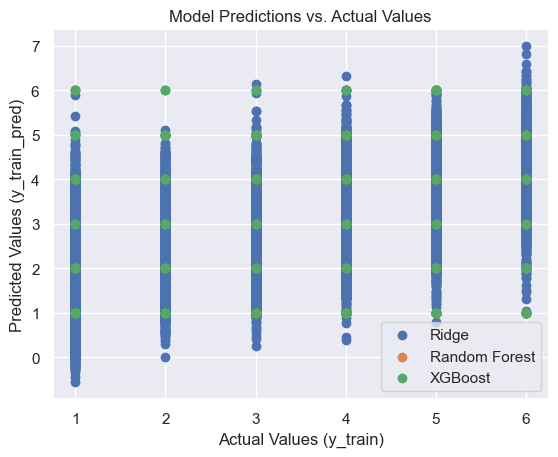

In [35]:
for model_name, y_train_pred in train_predictions.items():
    plt.scatter(y_train+1, y_train_pred+1, label=model_name)

plt.xlabel('Actual Values (y_train)')
plt.ylabel('Predicted Values (y_train_pred)')
plt.title('Model Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

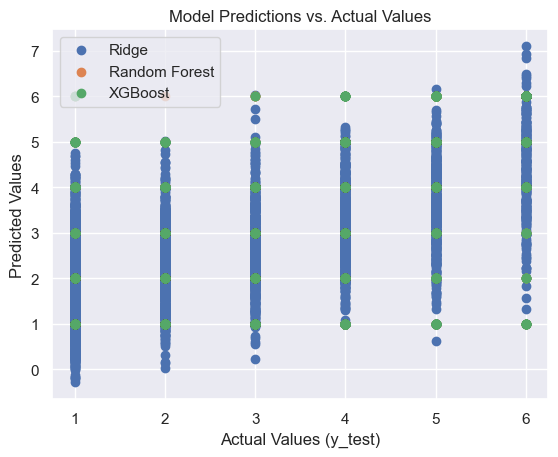

In [36]:
for model_name, y_pred in predictions.items():
    plt.scatter(y_test+1, y_pred+1, label=model_name)

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

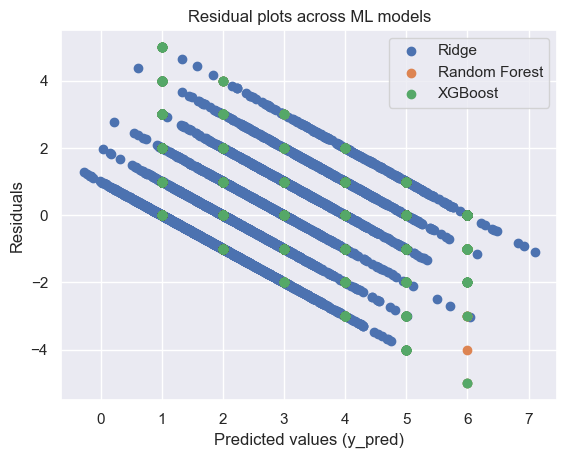

In [37]:
for model_name, y_pred in predictions.items():
    plt.scatter(y_pred+1, y_test - y_pred, label=model_name)

plt.xlabel('Predicted values (y_pred)')
plt.ylabel('Residuals')
plt.title('Residual plots across ML models')
plt.legend()
plt.grid(True)
plt.show()

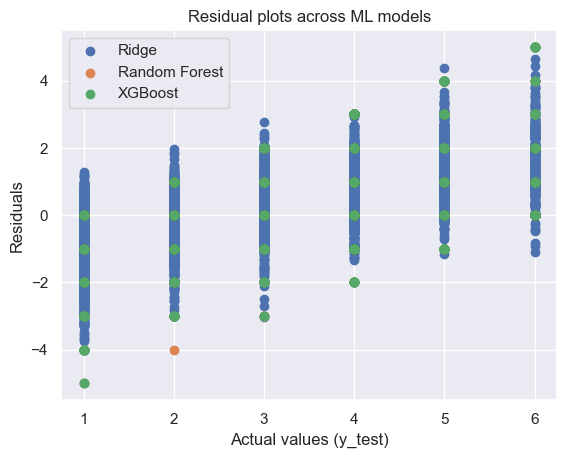

In [38]:
for model_name, y_pred in predictions.items():
    plt.scatter(y_test+1, y_test - y_pred, label=model_name)

plt.xlabel('Actual values (y_test)')
plt.ylabel('Residuals')
plt.title('Residual plots across ML models')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error', cv=5)
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = -np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training error', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, valid_scores_mean, label='Validation error', color='orange')
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color='orange')
    
    plt.xlabel('Training examples')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


In [40]:
# Assuming you have your X_train and y_train ready
# Let's visualize learning curves for one of your models, for example, RandomForestRegressor
# model = Ridge(**best_params['Ridge'])
# plot_learning_curves(model, X_train, y_train)

In [41]:
# model = XGBClassifier(**best_params['XGBoost'])
# plot_learning_curves(model, X_train, y_train)